# CLIPasso応用_感情分析_プレーン画像
**概要：**  
・顔画像から[happy, natural, angry, sad]の4つの感情を認識をする  
・[FER-2013](https://www.kaggle.com/datasets/msambare/fer2013)データセットを使用  
・VGG16への転移学習を行う  
・trainデータ、validationデータ、testデータにそれぞれの感情ごとに事前にフォルダ分割し、testデータの分類の通りの感情が最も高い数値で判定されれば判定成功とする  

## データセットの準備  

・各クラスごとに学習(train)3800枚以上/バリデーション(validation)320枚以上/予測(test)5枚以上分割  
・FER-2013のtrainをそのままtrainに、testフォルダをtestにそのまま使用。次にtestフォルダから任意の400枚をvalidationに移した   
・Google driveに以下のディレクトリ構成

```
dataset
├── train
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── angry
├── validation
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── angry
└── test
│   ├── happy
│   ├── neutral
│   ├── sad
│   └── angry
```

In [53]:
# # google drivenのファイル数カウントに使用
# import os
 
# # ファイル数を調べたいフォルダのパス
# path = '/content/drive/My Drive/world_model/test_emotion_detection/validation/angry'
 
# # フォルダ内の全ファイル名をリスト化
# files = os.listdir(path)
 
# # リストの長さ（ファイル数）を取得
# count = len(files)
 
# # ファイル数を確認
# print(count)

400


## 必要なライブラリのインポート

In [1]:
import os
import sys
import glob

import keras
import numpy as np
import matplotlib.pyplot as plt

from keras import optimizers
from keras.layers import Dense, Flatten, Input, Activation, add
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# 学習済みネットワーク
from keras.applications.vgg16 import VGG16\

## ハイパーパラメータの設定

In [54]:
# 分類
emotions = ['happy', 'neutral', 'angry', 'sad'] # 分類したい項目名（ディレクトリ名）
emotion_count = len(emotions)

image_width, image_height = 150, 150

# datasetディレクトリ
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/world_model/test_emotion_detection'

train_data_path = str(dataset_path) + '/train' 
validation_data_path = str(dataset_path) + '/validation' 
test_data_path = str(dataset_path) + '/test' 

# 重みデータを保存するディレクトリ
result_dir = '/content/drive/My Drive/world_model/test_emotion_detection'

# データの枚数
train_data_count = 3800
validation_data_count = 320

# バッチサイズ、エポック数
batch_size = 16
epoch_count = 50

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## データの生成（ジェネレータ）

In [55]:
# データ生成
datagen = ImageDataGenerator(
    rescale = 1.0/255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.39,
    horizontal_flip=True,
    samplewise_center=False,
    samplewise_std_normalization =False,
    zca_whitening=False)

In [56]:
generator_train = datagen.flow_from_directory(
    train_data_path,
    target_size=(image_width, image_height),
    color_mode='rgb',
    classes=emotions,
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=True)

generator_validation = datagen.flow_from_directory(
    validation_data_path, 
    target_size=(image_width, image_height),
    color_mode='rgb',
    classes=emotions,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

Found 21005 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.


## 学習済みVGG16の読み込みと全結合層の作成

In [57]:
# VGG16学習済みモデルの読み込み(RGB)
input_tensor = Input(shape=(image_width, image_height, 3))
learned_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# 全結合層の作成
full_model = Sequential()
full_model.add(Flatten(input_shape=learned_model.output_shape[1:]))
full_model.add(Dense(256, activation='relu',
                    kernel_initializer='he_normal'))
full_model.add(Dense(64, activation='relu',
                    kernel_initializer='he_normal'))
full_model.add(Dense(emotion_count, activation='softmax'))

# 学習済みデータと全結合層を結合
model = Model(inputs=learned_model.input, outputs=full_model(learned_model.output))

# 全結合層直前までの層を学習しないようにする
for layer in learned_model.layers[:15]:
    layer.trainable = False

# 学習処理の設定
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=optimizers.gradient_descent_v2.SGD(learning_rate=1e-3, momentum=0.9),
    metrics=['accuracy'])

## 学習
・実行時間はGoogle Clab Pro GPU/High-RAMで50分

In [58]:
# 学習
result = model.fit(
    generator_train,
    steps_per_epoch=train_data_count // batch_size,
    epochs=epoch_count,
    validation_data=generator_validation,
    validation_steps=validation_data_count // batch_size)

# 重みを保存
model.save_weights(os.path.join(result_dir, 'weight.h5'))

Epoch 1/50
237/237 [==============================] - 389s 2s/step - loss: 1.2943 - accuracy: 0.4098 - val_loss: 1.2353 - val_accuracy: 0.4344
Epoch 2/50
237/237 [==============================] - 297s 1s/step - loss: 1.1276 - accuracy: 0.5080 - val_loss: 1.1397 - val_accuracy: 0.4844
Epoch 3/50
237/237 [==============================] - 265s 1s/step - loss: 1.0665 - accuracy: 0.5419 - val_loss: 1.0658 - val_accuracy: 0.5156
Epoch 4/50
237/237 [==============================] - 208s 880ms/step - loss: 1.0284 - accuracy: 0.5625 - val_loss: 0.9957 - val_accuracy: 0.5375
Epoch 5/50
237/237 [==============================] - 176s 742ms/step - loss: 0.9888 - accuracy: 0.5781 - val_loss: 0.9379 - val_accuracy: 0.5906
Epoch 6/50
237/237 [==============================] - 150s 632ms/step - loss: 0.9616 - accuracy: 0.5893 - val_loss: 0.9601 - val_accuracy: 0.5813
Epoch 7/50
237/237 [==============================] - 130s 547ms/step - loss: 0.9367 - accuracy: 0.6023 - val_loss: 0.9262 - val_accu

## 学習結果の表示

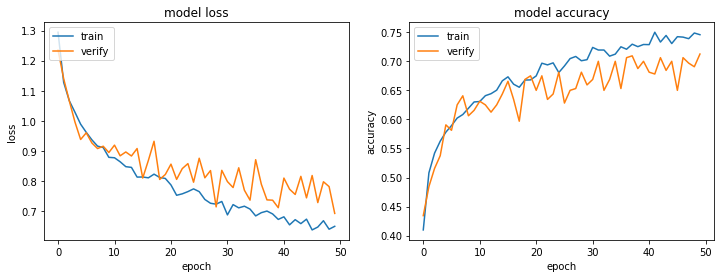

In [59]:
fig = plt.figure(figsize=(12,4))

# subplot
# loss
sub_loss = fig.add_subplot(1,2,1)
sub_loss.plot(result.history['loss'])
sub_loss.plot(result.history['val_loss'])
sub_loss.set_title('model loss')
sub_loss.set_ylabel('loss')
sub_loss.set_xlabel('epoch')
sub_loss.legend(['train', 'verify'], loc='upper left')

#Accuracy
sub_acc = fig.add_subplot(1,2,2)
sub_acc.plot(result.history['accuracy'])
sub_acc.plot(result.history['val_accuracy'])
sub_acc.set_title('model accuracy')
sub_acc.set_ylabel('accuracy')
sub_acc.set_xlabel('epoch')
sub_acc.legend(['train', 'verify'], loc='upper left')

## テストデータでの予測

In [60]:
def test_predict(filepath_list):
    
    # 各クラスの予測画像枚数
    num_test = 5

    count = 0
    for i in filepath_list:
        # 画像を読み込んで4次元テンソルへ変換
        img = image.load_img(i, target_size=(image_height, image_width))
        xarray = image.img_to_array(img)
        x = np.expand_dims(xarray, axis=0)
        # テストデータも正規化
        x = x / 255.0

        # 予測 入力は1枚の画像なので[0]のみ
        pred = model.predict(x)[0]
        
        # 描画　topの数だけ予測確率が高い結果を出力
        fig = plt.figure(figsize=(2,2))
        top = 3
        top_indices = pred.argsort()[-top:][::-1]
        result = [(emotions[i], pred[i]) for i in top_indices]
        [print(x) for x in result]
        plt.imshow(img)
        plt.show()
        
        print('------------------------------------')

        count += 1
        if count == num_test: break



<<HAPPY>>

('happy', 0.98509467)
('neutral', 0.007925353)
('sad', 0.004022389)


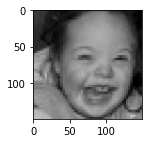

------------------------------------
('happy', 0.9469019)
('neutral', 0.04960444)
('sad', 0.0019591458)


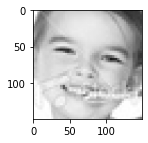

------------------------------------
('happy', 0.9986513)
('neutral', 0.0011877352)
('sad', 0.00013787026)


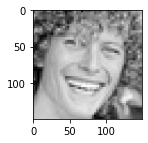

------------------------------------
('happy', 0.9978205)
('neutral', 0.0018186552)
('angry', 0.00025701738)


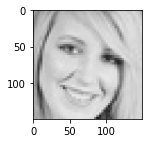

------------------------------------
('happy', 0.9976058)
('neutral', 0.0018845819)
('sad', 0.0002662541)


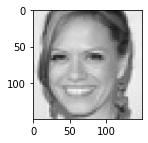

------------------------------------


<<NEUTRAL>>

('neutral', 0.9387174)
('sad', 0.040553693)
('angry', 0.020063879)


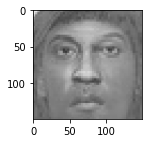

------------------------------------
('neutral', 0.6483042)
('sad', 0.29437116)
('angry', 0.05413648)


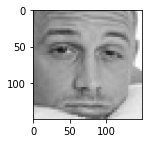

------------------------------------
('sad', 0.5620596)
('angry', 0.27050415)
('neutral', 0.1635655)


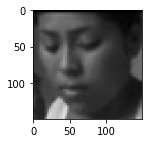

------------------------------------
('neutral', 0.6745233)
('sad', 0.2388972)
('angry', 0.08594201)


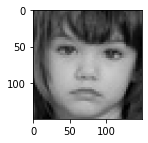

------------------------------------
('neutral', 0.5419479)
('sad', 0.36745673)
('angry', 0.0874186)


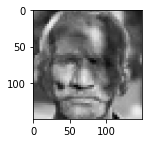

------------------------------------


<<ANGRY>>

('angry', 0.553161)
('sad', 0.27438244)
('neutral', 0.14055453)


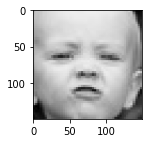

------------------------------------
('sad', 0.44819406)
('neutral', 0.4152121)
('angry', 0.12694438)


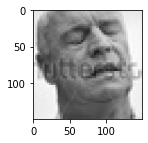

------------------------------------
('angry', 0.9057586)
('sad', 0.08086287)
('neutral', 0.013319401)


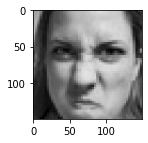

------------------------------------
('sad', 0.62448496)
('neutral', 0.32562968)
('angry', 0.047836762)


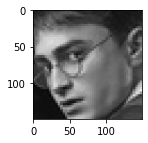

------------------------------------
('neutral', 0.4452396)
('sad', 0.38361058)
('angry', 0.16846487)


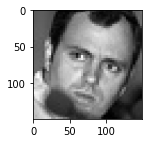

------------------------------------


<<SAD>>

('sad', 0.9145593)
('neutral', 0.04795676)
('angry', 0.036864053)


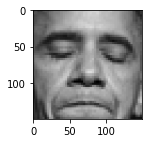

------------------------------------
('sad', 0.7608662)
('neutral', 0.15436915)
('angry', 0.08338793)


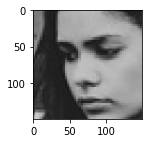

------------------------------------
('neutral', 0.54264253)
('sad', 0.421365)
('angry', 0.034031045)


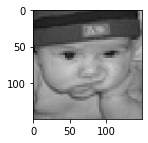

------------------------------------
('neutral', 0.5175902)
('sad', 0.25498194)
('angry', 0.22328627)


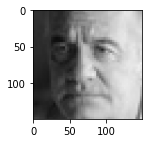

------------------------------------
('sad', 0.6571322)
('neutral', 0.19108802)
('angry', 0.14031462)


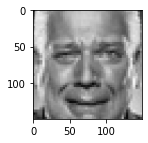

------------------------------------


In [61]:
for x in emotions:
    print('\n\n<<'+ str(x).upper() + '>>\n')
    filepath_list = glob.glob(str(test_data_path)  + '/' + str(x) + '/*')
    test_predict(filepath_list)

**リファレンス**  
[「少ないデータで転移学習を用いて画像内の表情を分類する」](https://github.com/zarakima/face-classification)   